# 10 Animals classification

https://www.kaggle.com/datasets/alessiocorrado99/animals10

## Download and preparation

* Donwload the data from Kaggle
* Unzip the file
* Prepare the data in appropriate folder structure splitting randomnly into test and train datasets
* Move pictures accordingly

In [2]:
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import shutil
import os
import zipfile
import torchvision

from pathlib import Path
from timeit import default_timer as timer
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_random_state
from tqdm.auto import tqdm

In [4]:
#check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    device = "mps"
    print (x)
else:
    device = "cpu"
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [12]:
os.chdir("../10animals")

In [142]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [144]:
with zipfile.ZipFile("animals10.zip", "r") as zip_ref:
    print("Unzipping animals...")
    zip_ref.extractall("../10animals")

Unzipping animals...


In [146]:
animal_folders = list(Path("raw-img/").glob("*/"))
animal_folders

[PosixPath('raw-img/gallina'),
 PosixPath('raw-img/ragno'),
 PosixPath('raw-img/gatto'),
 PosixPath('raw-img/farfalla'),
 PosixPath('raw-img/mucca'),
 PosixPath('raw-img/cavallo'),
 PosixPath('raw-img/cane'),
 PosixPath('raw-img/pecora'),
 PosixPath('raw-img/scoiattolo'),
 PosixPath('raw-img/elefante')]

In [18]:
train_dir = Path("train/")
test_dir = Path("test/")
# train_dir.mkdir()
# test_dir.mkdir()

In [ ]:
for animal in animal_folders:
    # destination folders
    destination_train = train_dir / animal.name
    destination_train.mkdir(parents=True, exist_ok=True)
    destination_test = test_dir / animal.name
    destination_test.mkdir(parents=True, exist_ok=True)
    # list of images to be moved
    img_list = pd.DataFrame(list(animal.glob("*.jpg")) + list(animal.glob("*.jpeg")) + list(animal.glob("*.png")))
    print(f"There are {len(img_list)} in the {animal.name} folder")
    train_size = int(len(img_list)*0.8)
    train_img = img_list.iloc[:train_size]
    test_img = img_list.iloc[train_size:]
    print(len(train_img), len(test_img), len(img_list))
    # moving the files
    for file_name in train_img.iloc[:,0]:
        shutil.move(os.path.join(animal, Path(file_name).name), destination_train)
    for file_name in test_img.iloc[:,0]:
        shutil.move(os.path.join(animal, Path(file_name).name), destination_test)
    os.rmdir(animal)
os.rmdir(animal_folders[1].parent)

## Create test and train datasets

In [6]:
os.chdir("../PyTorch_course")

In [8]:
import cnn_functions as cnn

In [10]:
os.chdir("../10animals")

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [20]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
len(train_data)

20938

In [22]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
len(test_data)

5241

In [24]:
class_names = train_data.classes
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

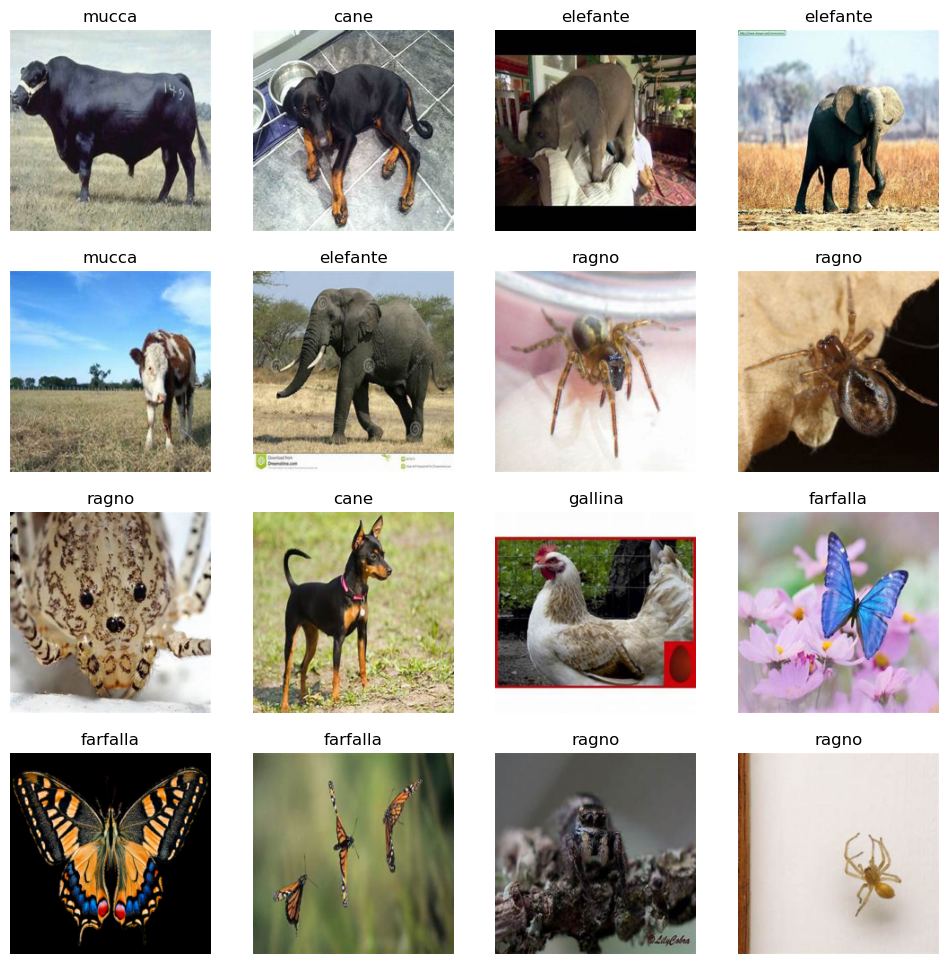

In [26]:
plt.figure(figsize=(12, 12))

for j in range(16):
  plt.subplot(4, 4, j+1)
  random_image = random.choice(range(len(test_data)))
  plt.imshow(test_data[random_image][0].permute(1, 2, 0))
  plt.title(class_names[test_data[random_image][1]])
  plt.axis(False);

## VGG11 from PyTorch library

In [29]:
weights = torchvision.models.VGG11_Weights.IMAGENET1K_V1

In [31]:
vgg11 = torchvision.models.vgg11(weights=weights).to(device)

In [32]:
for param in vgg11.features.parameters():
  param.requires_grad = False

In [33]:
vgg11.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = len(class_names))).to(device)
vgg11.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [37]:
normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise])

In [39]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=manual_transforms,
                                  target_transform=None)
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)

In [41]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=manual_transforms,
                                 target_transform=None)
test_dataloader = DataLoader(test_data,
                              batch_size=32,
                              shuffle=True)

In [43]:
torch.manual_seed(100)
optimizer = torch.optim.SGD(vgg11.parameters(),
                            lr=0.001)

In [45]:
vgg11_start_time = timer()
vgg11_results = cnn.train(vgg11,
                          train_dataloader,
                          test_dataloader,
                          optimizer,
                          epochs=2,
                          device=device)
vgg11_end_time = timer()
(vgg11_end_time - vgg11_start_time)/60

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.38913 | Train acc: 0.59443 | Test loss: 0.69075 | Test acc: 0.86874
Epoch: 2 | Train loss: 0.56484 | Train acc: 0.86073 | Test loss: 0.36488 | Test acc: 0.91572


472.4699509999482

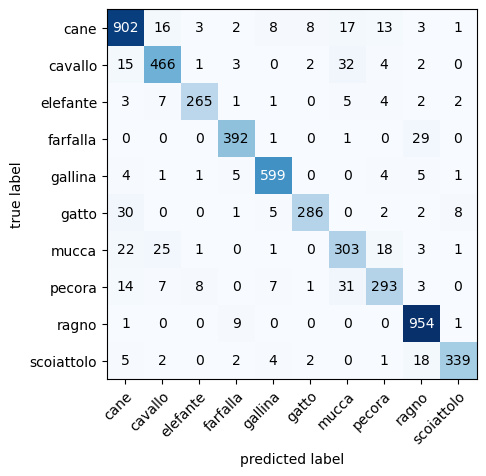

In [54]:
cnn.confusion_matrix_plot(vgg11, test_dataloader, class_names)